In [ ]:
import sys
import os
import numpy as np
import mne
import matplotlib.pyplot as plt
import pickle
from collections import defaultdict

# Add the workspace root to the Python path
workspace_root = os.path.abspath("..")
if workspace_root not in sys.path:
    sys.path.append(workspace_root)

from functions import preprocess

# List of subject IDs
ids = list(range(601, 618))

# Dictionary to store bridged channels for different LM cutoffs
all_bridged_channels = {}

# Define the two LM cutoff values to test
lm_cutoffs = [5, 16]  # As mentioned in your variable

for lm_cutoff in lm_cutoffs:
    # Dictionary to store bridged channels for all subjects at this cutoff
    bridged_channels_dict = {}
    
    for i, id in enumerate(ids):
        try:
            # Preprocess the data for each subject
            print(f"Processing subject {id} with LM cutoff {lm_cutoff}...")
            subject = preprocess(id)
            epochs = subject.epoching(tmin=-0.2, tmax=0.8, baseline=(None, 0))
            bridged_idx, ed_matrix, bridged_ch_names = subject.bridged_channels(
                epochs, 
                lm_cutoff=lm_cutoff, 
                epoch_threshold=0.5
            )
            
            # Save bridged channels information in the dictionary
            bridged_channels_dict[id] = {
                "bridged_idx": bridged_idx,
                "ed_matrix": ed_matrix,
                "bridged_ch_names": bridged_ch_names
            }
            print(f"Found {len(bridged_ch_names)} bridged channels for subject {id}")
        except Exception as e:
            print(f"Error processing subject {id}: {e}")
            bridged_channels_dict[id] = {
                "bridged_idx": [],
                "ed_matrix": None,
                "bridged_ch_names": [],
                "error": str(e)
            }
    
    # Store results for this LM cutoff
    all_bridged_channels[lm_cutoff] = bridged_channels_dict

# Save the results
output_dir = os.path.join(workspace_root, "results")
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, "bridged_channels_analysis.pkl")
with open(output_path, 'wb') as f:
    pickle.dump(all_bridged_channels, f)


Saved bridged channels analysis to c:\Users\gmoha\Downloads\git\preprocessing_pipline\results\bridged_channels_analysis.pkl


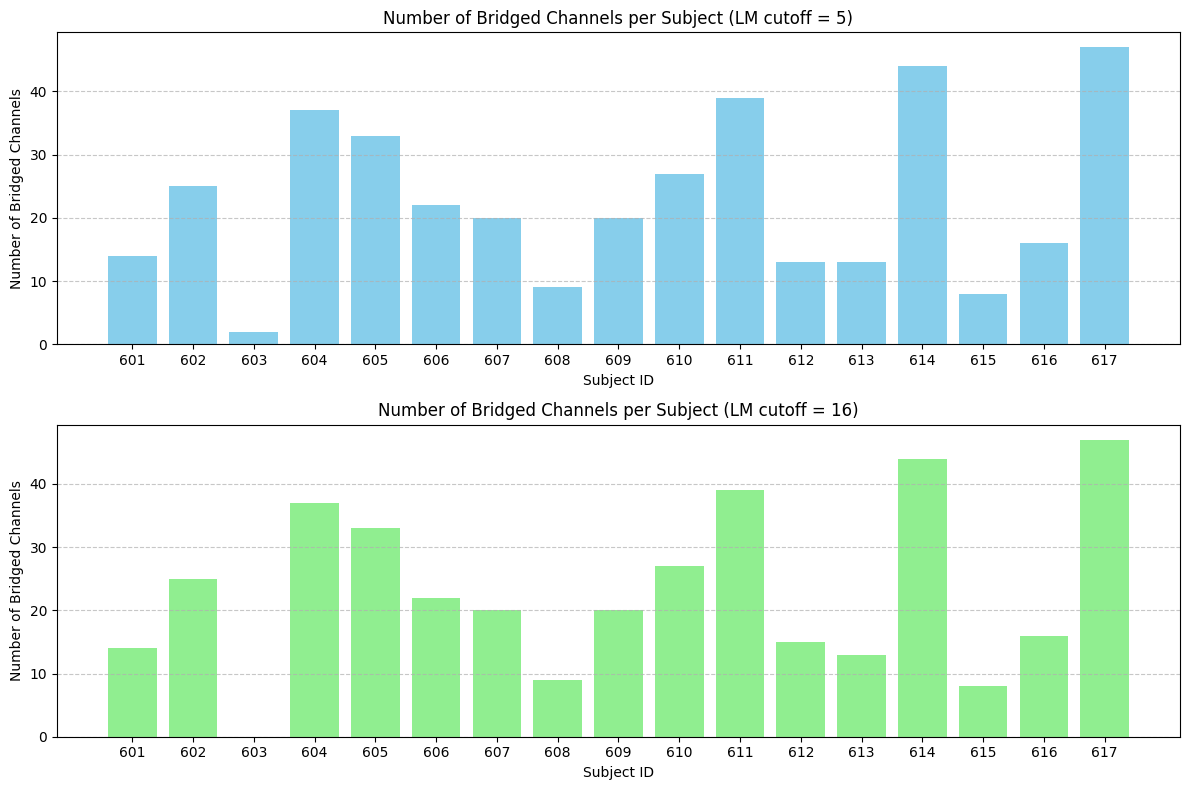

Average number of bridged channels by LM cutoff:
LM cutoff 5: 22.88 channels
LM cutoff 16: 22.88 channels


In [2]:
with open(output_path, 'wb') as f:
    pickle.dump(all_bridged_channels, f)

print(f"Saved bridged channels analysis to {output_path}")

# Visualization of results for both cutoffs
plt.figure(figsize=(12, 8))

for i, lm_cutoff in enumerate(lm_cutoffs):
    bridged_channels_dict = all_bridged_channels[lm_cutoff]
    subject_ids = list(bridged_channels_dict.keys())
    
    # Calculate number of bridged channels for each subject
    num_bridged_channels = [len(bridged_channels_dict[id]["bridged_ch_names"]) 
                           for id in subject_ids]
    
    # Plot as subplot
    plt.subplot(2, 1, i+1)
    plt.bar(subject_ids, num_bridged_channels, color=['skyblue', 'lightgreen'][i])
    plt.xlabel('Subject ID')
    plt.ylabel('Number of Bridged Channels')
    plt.title(f'Number of Bridged Channels per Subject (LM cutoff = {lm_cutoff})')
    plt.xticks(subject_ids)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "bridged_channels_comparison.png"))
plt.show()

# Compare average number of bridged channels between cutoffs
avg_bridged_by_cutoff = {}
for lm_cutoff in lm_cutoffs:
    bridged_channels_dict = all_bridged_channels[lm_cutoff]
    avg_num = np.mean([len(bridged_channels_dict[id]["bridged_ch_names"]) for id in bridged_channels_dict])
    avg_bridged_by_cutoff[lm_cutoff] = avg_num
    
print("Average number of bridged channels by LM cutoff:")
for cutoff, avg in avg_bridged_by_cutoff.items():
    print(f"LM cutoff {cutoff}: {avg:.2f} channels")

In [ ]:
# Load the previously saved data
# Save the results
import sys
import os
import numpy as np
import mne
import matplotlib.pyplot as plt
import pickle
from collections import defaultdict

# Add the workspace root to the Python path
workspace_root = os.path.abspath("..")
if workspace_root not in sys.path:
    sys.path.append(workspace_root)

from functions import preprocess
output_dir = os.path.join(workspace_root, "results")
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, "bridged_channels_analysis.pkl")
with open(output_path, 'rb') as f:
    all_bridged_channels = pickle.load(f)

# Get the data for cutoff of 5
cutoff_5_data = all_bridged_channels[5]
subject_ids = list(cutoff_5_data.keys())

# Create a directory for saving individual plots
plots_dir = os.path.join(output_dir, "bridged_electrodes_plots")
os.makedirs(plots_dir, exist_ok=True)

# Create a figure with subplots for a summary visualization
plt.figure(figsize=(16, 10))

# Dictionary to store raw objects for each subject
info = {}

# Plot bridged electrodes for each subject
for i, sub in enumerate(subject_ids):
    bridged_data = cutoff_5_data[sub]
    bridged_idx = bridged_data["bridged_idx"]
    ed_matrix = bridged_data["ed_matrix"]
    bridged_ch_names = bridged_data["bridged_ch_names"]
    
    # Skip subjects with errors or no bridged channels
    if ed_matrix is None or len(bridged_idx) == 0:
        print(f"Skipping Subject {sub}: No bridged channels or error occurred")
        continue
    
    # Load raw data for this subject if not already loaded
    if sub not in info:
        try:
            subject = preprocess(sub)
            epochs = subject.epoching(tmin=-0.2, tmax=0.8, baseline=(None, 0))
            info[sub] = epochs.info
        except Exception as e:
            print(f"Error loading data for Subject {sub}: {e}")
            continue
    
    # Plot the bridged electrodes for this subject
    print(f"Plotting bridged electrodes for Subject {sub}")
    fig = mne.viz.plot_bridged_electrodes(
        info[sub],
        bridged_idx,
        ed_matrix,
        title=f"Subject {sub} Bridged Electrodes (LM cutoff = 5) (n={len(bridged_ch_names)})",
        topomap_args=dict(vlim=(None, 5)),
    )
    
    # Save the figure
    fig_path = os.path.join(plots_dir, f"subject_{sub}_bridged_electrodes.png")
    fig.savefig(fig_path, dpi=300, bbox_inches='tight')
    plt.close(fig)  # Close the figure to free memory

# Create and save a summary plot showing the number of bridged channels per subject
plt.figure(figsize=(12, 6))
num_bridged_channels = [len(cutoff_5_data[id]["bridged_ch_names"]) for id in subject_ids]
plt.bar(subject_ids, num_bridged_channels, color='skyblue')
plt.xlabel('Subject ID')
plt.ylabel('Number of Bridged Channels')
plt.title('Number of Bridged Channels per Subject (LM cutoff = 5)')
plt.xticks(subject_ids)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, "summary_bridged_channels_cutoff5.png"), dpi=300)
plt.show()

# Print a summary of the bridged channels for each subject
print("\nSummary of bridged channels (LM cutoff = 5):")
for sub in subject_ids:
    bridged_ch_names = cutoff_5_data[sub]["bridged_ch_names"]
    if bridged_ch_names:
        print(f"Subject {sub}: {len(bridged_ch_names)} bridged channels - {', '.join(bridged_ch_names)}")
    else:
        print(f"Subject {sub}: No bridged channels")
        

Text(0, 0.5, 'Count (channel pairs for all epochs)')

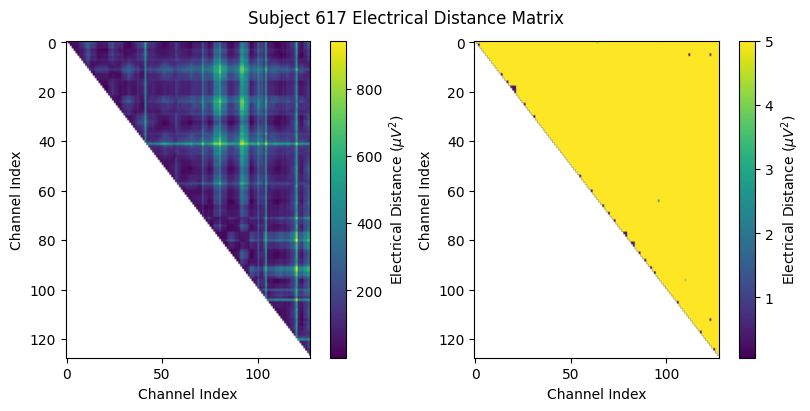

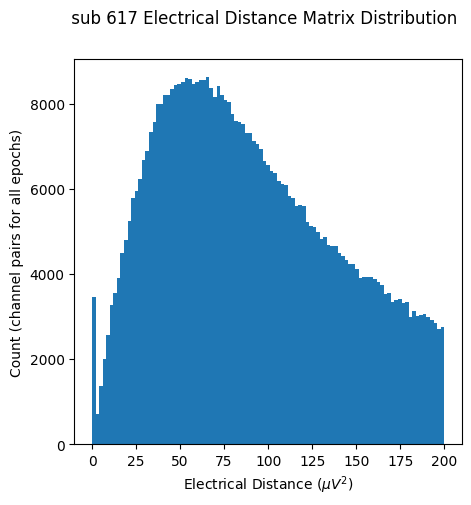

In [11]:
sub = 617
bridged_data = cutoff_5_data[sub]
bridged_idx = bridged_data["bridged_idx"]
ed_matrix = bridged_data["ed_matrix"]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), layout="constrained")
fig.suptitle(f"Subject {sub} Electrical Distance Matrix")

# take median across epochs, only use upper triangular, lower is NaNs
ed_plot = np.zeros(ed_matrix.shape[1:]) * np.nan
triu_idx = np.triu_indices(ed_plot.shape[0], 1)
for idx0, idx1 in np.array(triu_idx).T:
    ed_plot[idx0, idx1] = np.nanmedian(ed_matrix[:, idx0, idx1])

# plot full distribution color range
im1 = ax1.imshow(ed_plot, aspect="auto")
cax1 = fig.colorbar(im1, ax=ax1)
cax1.set_label(r"Electrical Distance ($\mu$$V^2$)")

# plot zoomed in colors
im2 = ax2.imshow(ed_plot, aspect="auto", vmax=5)
cax2 = fig.colorbar(im2, ax=ax2)
cax2.set_label(r"Electrical Distance ($\mu$$V^2$)")
for ax in (ax1, ax2):
    ax.set_xlabel("Channel Index")
    ax.set_ylabel("Channel Index")

fig, ax = plt.subplots(figsize=(5, 5))
fig.suptitle(f" sub {sub} Electrical Distance Matrix Distribution")
ax.hist(ed_matrix[~np.isnan(ed_matrix)], bins=np.linspace(0, 200, 100))
ax.set_xlabel(r"Electrical Distance ($\mu$$V^2$)")
ax.set_ylabel("Count (channel pairs for all epochs)")

In [13]:
raw = preprocess(sub).raw
raw_filtered = raw.copy().filter(l_freq=1, h_freq=40)  # Apply bandpass filter
# Create new channels by subtracting data from pairs of channels
new_channels = []
new_channel_names = []
for ch1, ch2 in bridged_idx:
    data = raw_filtered.get_data(picks=[ch1]) - raw_filtered.get_data(picks=[ch2])  # Subtract channel data
    new_channels.append(data)
    new_channel_names.append(f"{ch1}-{ch2}")

# Combine new channels into a RawArray
new_raw = mne.io.RawArray(
    np.vstack(new_channels),  # Stack new channel data
    mne.create_info(new_channel_names, raw.info["sfreq"], ch_types="eeg")
)

Extracting EDF parameters from c:\Users\gmoha\Downloads\git\preprocessing_pipline\Data\O_617_Def_OF.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 455167  =      0.000 ...   888.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



c:\Users\gmoha\Downloads\git\preprocessing_pipline\functions.py:24: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  xyz_data = pd.read_csv(ch_location_path, delim_whitespace=True, skiprows=1, header=None)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.7s


Creating RawArray with float64 data, n_channels=34, n_times=455168
    Range : 0 ... 455167 =      0.000 ...   888.998 secs
Ready.


C:\Users\gmoha\AppData\Local\Temp\ipykernel_14212\773488009.py:14: RuntimeWarning: Channel names are not unique, found duplicates for: {'2-3'}. Applying running numbers for duplicates.
  mne.create_info(new_channel_names, raw.info["sfreq"], ch_types="eeg")


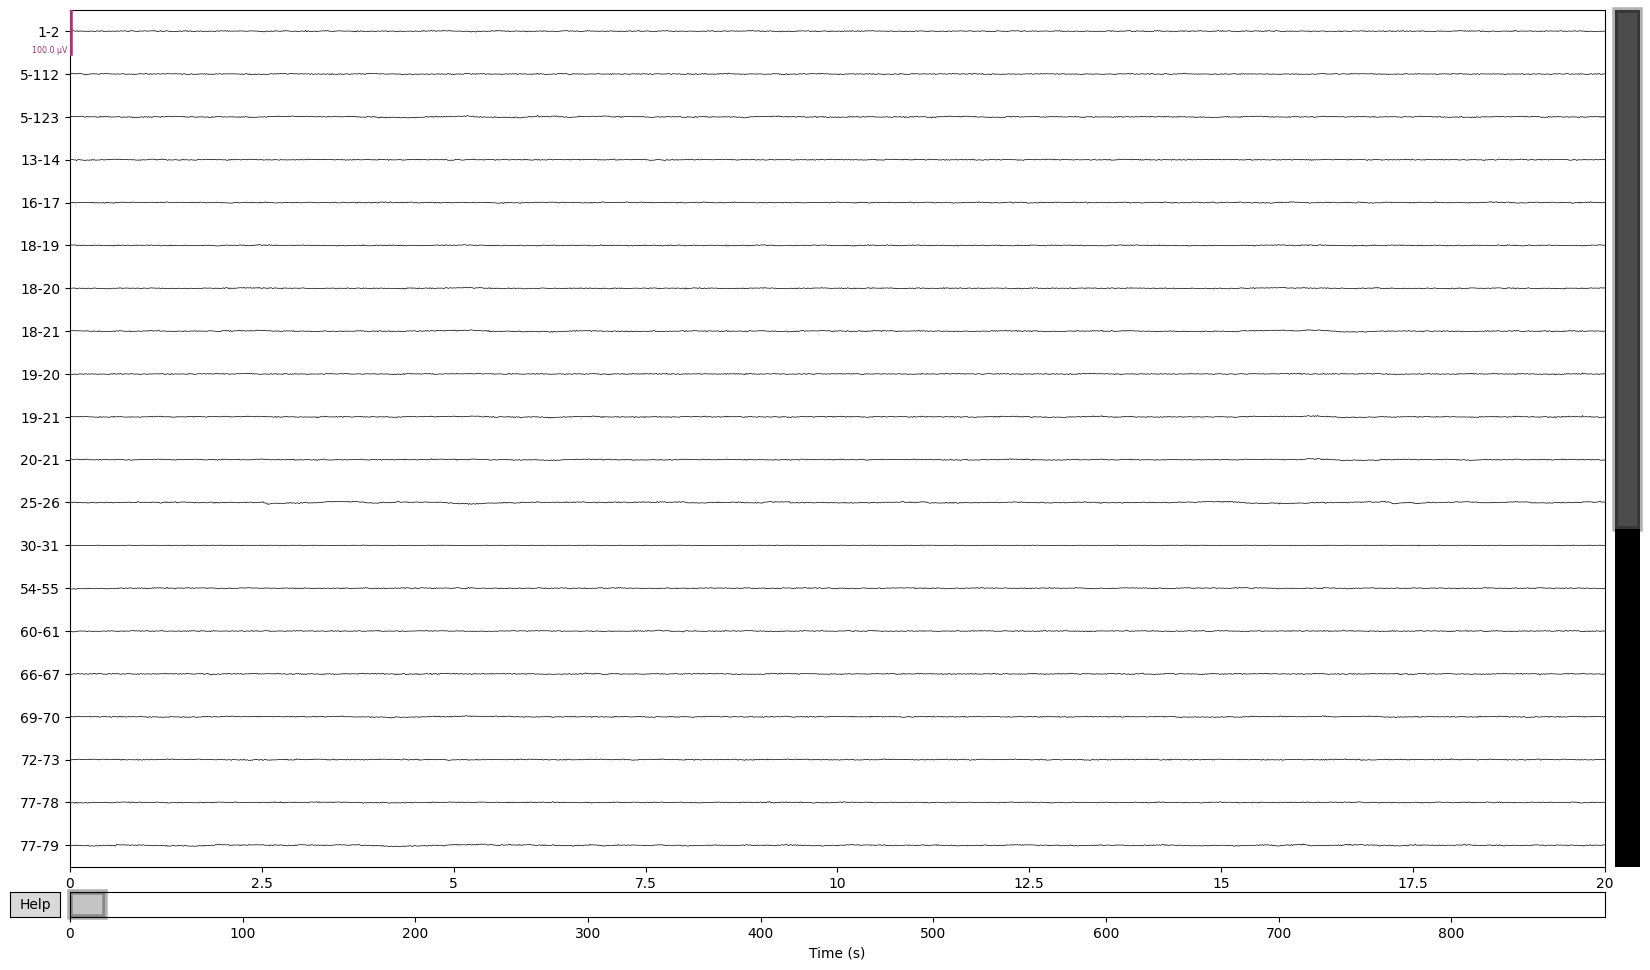

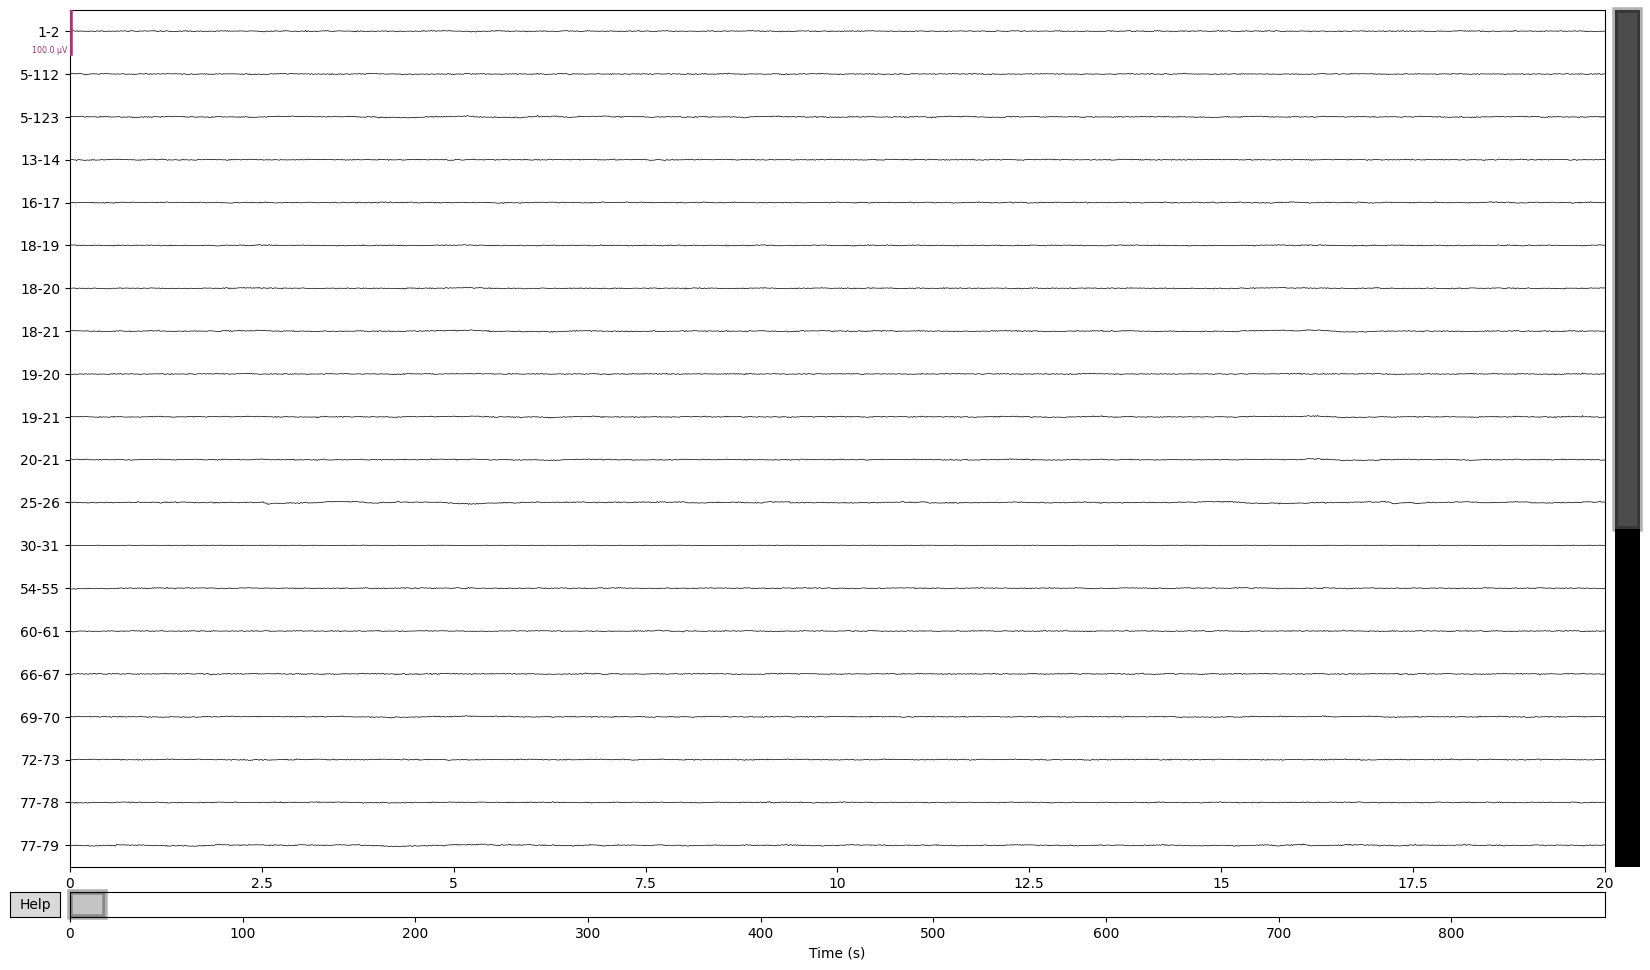

In [12]:
new_raw.plot(duration=20, scalings=dict(eeg=50e-6), block=True, show_options=True, title='Filtered EEG Data', color='black')

In [19]:
# raw = preprocess(sub).raw
# raw_filtered = raw.copy().filter(l_freq=1, h_freq=40)  # Apply bandpass filter
# # Create new channels by subtracting data from pairs of channels
# new_channels = []
# new_channel_names = []
bridged_idx = [(1,2),(2,3), (3,4)]  # Example bridged channels
for ch1, ch2 in bridged_idx:
    data = raw_filtered.get_data(picks=[ch1]) - raw_filtered.get_data(picks=[ch2])  # Subtract channel data
    new_channels.append(data)
    new_channel_names.append(f"{ch1}-{ch2}")

# Combine new channels into a RawArray
new_raw = mne.io.RawArray(
    np.vstack(new_channels),  # Stack new channel data
    mne.create_info(new_channel_names, raw.info["sfreq"], ch_types="eeg")
)

Creating RawArray with float64 data, n_channels=3, n_times=455168
    Range : 0 ... 455167 =      0.000 ...   888.998 secs
Ready.


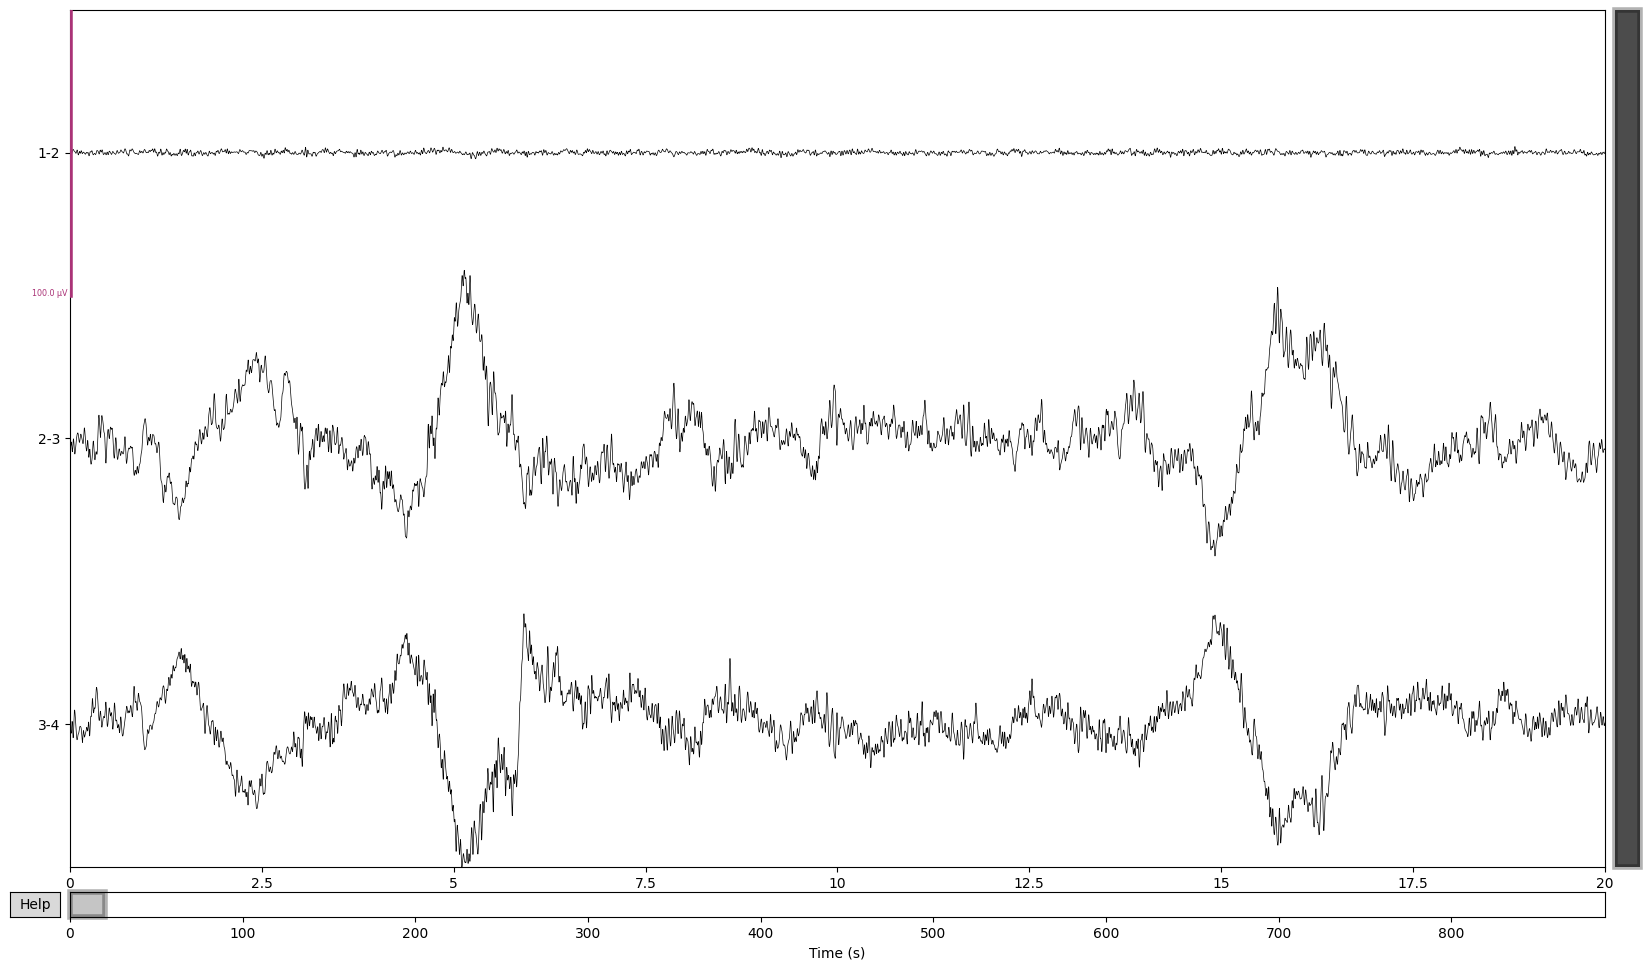

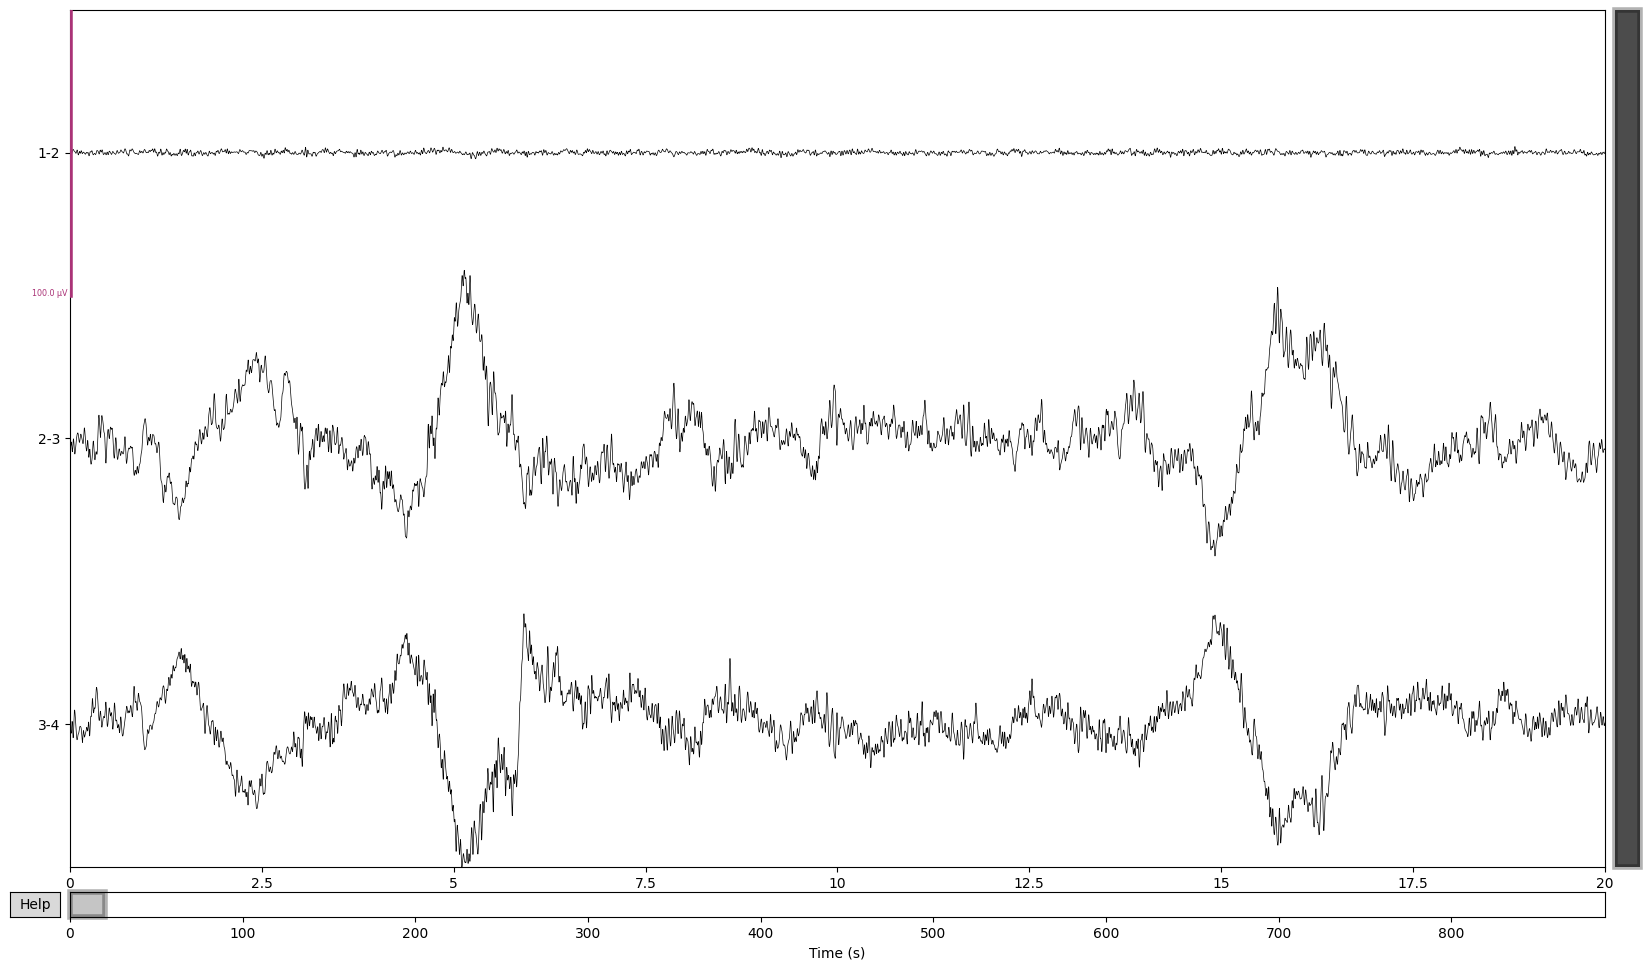

In [20]:
new_raw.plot(duration=20, scalings=dict(eeg=50e-6), block=True, show_options=True, title='Filtered EEG Data', color='black')

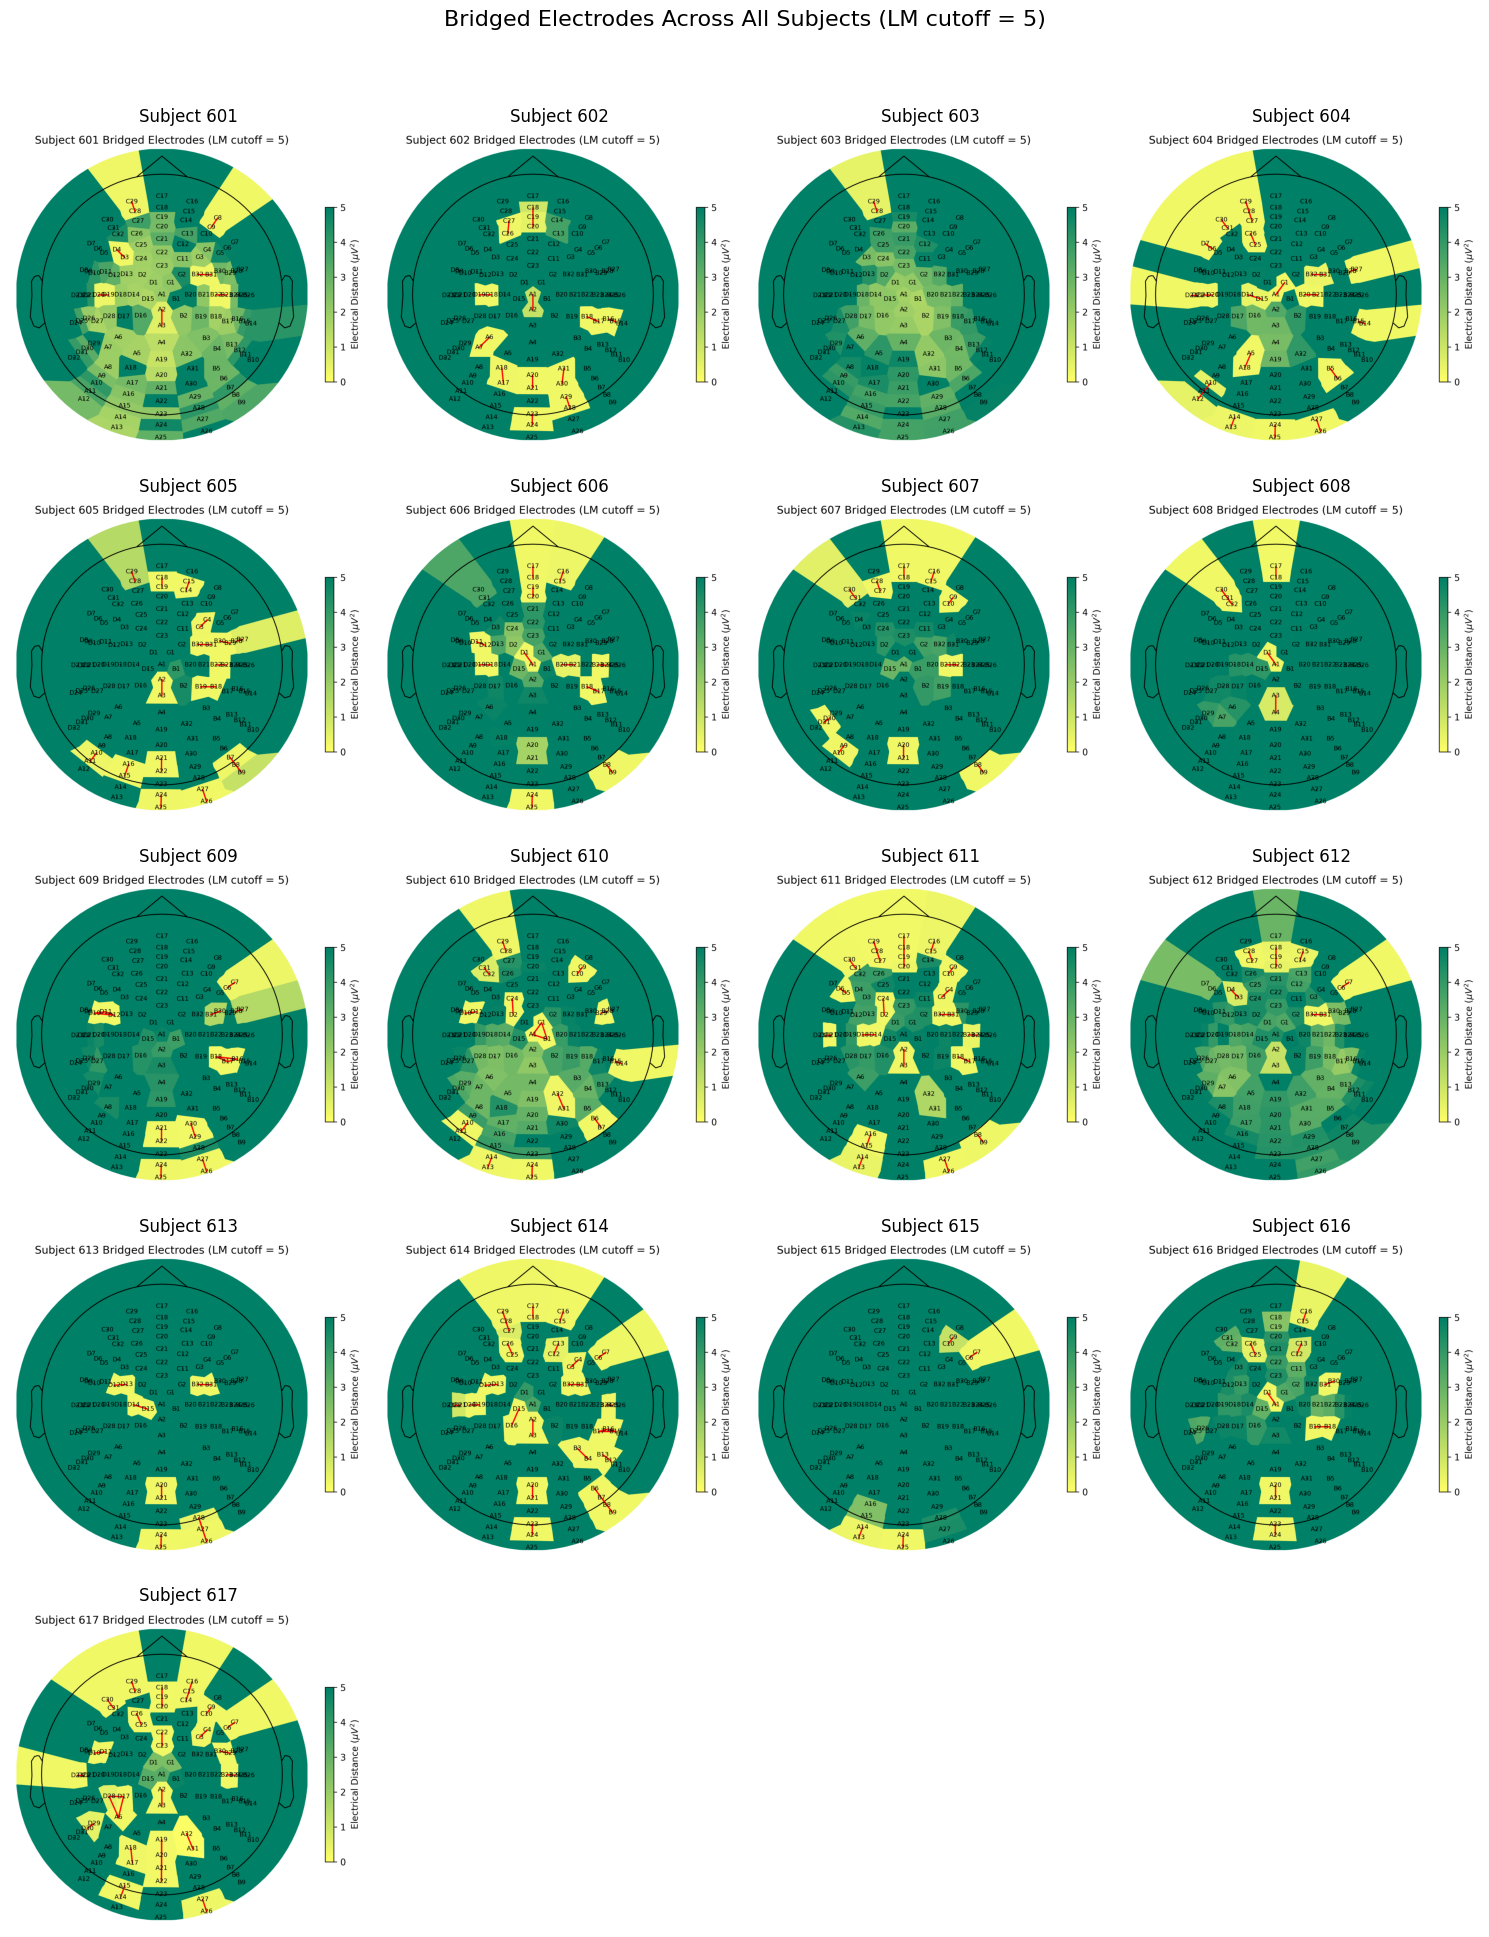

In [3]:
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image

# Directory containing the images
plots_dir = os.path.join(output_dir, "bridged_electrodes_plots")

# Get all subject image files
subject_files = sorted([f for f in os.listdir(plots_dir) 
                       if f.startswith("subject_") and f.endswith("_bridged_electrodes.png")])

# Calculate grid dimensions
n_images = len(subject_files)
n_cols = 4  # Adjust based on how many columns you want
n_rows = int(np.ceil(n_images / n_cols))

# Create a figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
fig.suptitle("Bridged Electrodes Across All Subjects (LM cutoff = 5)", fontsize=16)

# If there's only one row, ensure axes is 2D
if n_rows == 1:
    axes = axes.reshape(1, -1)

# Plot each image
for i, img_file in enumerate(subject_files):
    # Calculate row and column indices
    row_idx = i // n_cols
    col_idx = i % n_cols
    
    # Extract subject ID from filename
    subject_id = img_file.split('_')[1]
    
    # Load image
    img_path = os.path.join(plots_dir, img_file)
    img = Image.open(img_path)
    
    # Plot image
    axes[row_idx, col_idx].imshow(np.array(img))
    axes[row_idx, col_idx].set_title(f"Subject {subject_id}")
    axes[row_idx, col_idx].axis('off')

# Turn off any empty subplots
for i in range(n_images, n_rows * n_cols):
    row_idx = i // n_cols
    col_idx = i % n_cols
    axes[row_idx, col_idx].axis('off')
    axes[row_idx, col_idx].set_visible(False)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout, leaving room for suptitle
plt.savefig(os.path.join(output_dir, "all_subjects_bridged_electrodes.png"), dpi=300, bbox_inches='tight')
plt.show()

C:\Users\gmoha\AppData\Local\Temp\ipykernel_21396\2171216984.py:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  local_min_val = float(result.x)


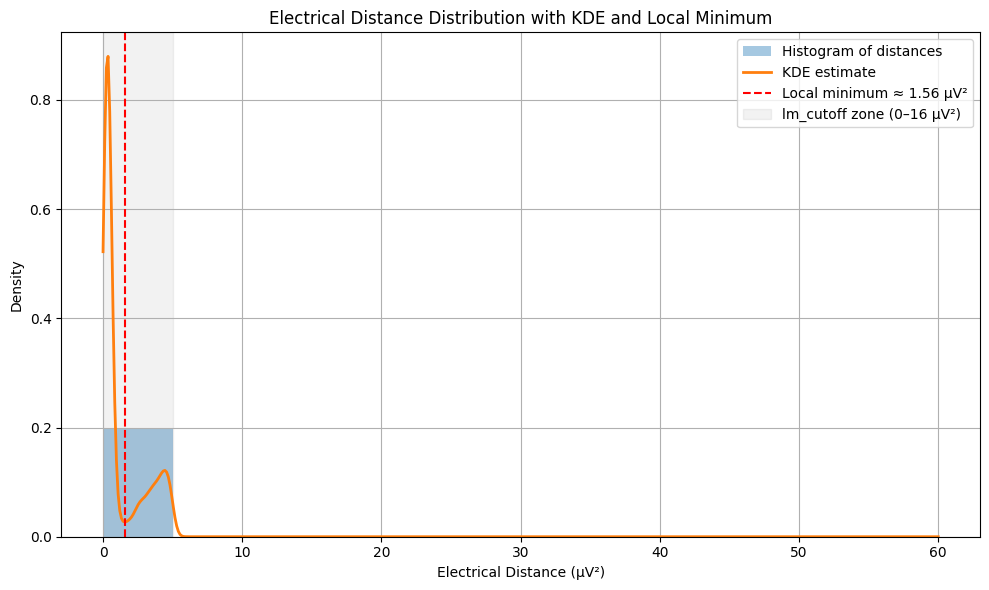

In [14]:
# Load the previously saved data
# Save the results
import sys
import os
import numpy as np
import mne
import matplotlib.pyplot as plt
import pickle
from collections import defaultdict
from scipy.stats import gaussian_kde
from scipy.optimize import minimize_scalar
sub = 617
# Add the workspace root to the Python path
workspace_root = os.path.abspath("..")
if workspace_root not in sys.path:
    sys.path.append(workspace_root)

from functions import preprocess
output_dir = os.path.join(workspace_root, "results")
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, "bridged_channels_analysis.pkl")
with open(output_path, 'rb') as f:
    all_bridged_channels = pickle.load(f)

# Get the data for cutoff of 5
cutoff_5_data = all_bridged_channels[5]
bridged_data = cutoff_5_data[sub]
ed_matrix = bridged_data["ed_matrix"]


# Assuming ed_matrix is already loaded from the user's data
# Step 1: Extract upper triangle values (excluding diagonal) across all epochs

n_epochs, n_channels, _ = ed_matrix.shape
upper_triangle_indices = np.triu_indices(n_channels, k=1)

# Extract all relevant values
ed_values = ed_matrix[:, upper_triangle_indices[0], upper_triangle_indices[1]].flatten()

# Remove any NaNs
ed_values = ed_values[~np.isnan(ed_values)]

# Step 2: Compute KDE on values below lm_cutoff (default 16 µV²)
lm_cutoff = 5
subset = ed_values[ed_values < lm_cutoff]

kde = gaussian_kde(subset)

# Step 3: Evaluate KDE
x_vals = np.linspace(0, 60, 500)
kde_vals = kde(x_vals)

# Step 4: Find local minimum
def objective(x):
    return kde(x) if 0 < x < lm_cutoff else np.inf

result = minimize_scalar(objective, bounds=(0, lm_cutoff), method='bounded')
local_min_val = float(result.x)

# Step 5: Plotting
plt.figure(figsize=(10, 6))
plt.hist(ed_values, bins=1, density=True, alpha=0.4, label="Histogram of distances", range=(0, 5))
plt.plot(x_vals, kde_vals, label="KDE estimate", linewidth=2)
plt.axvline(local_min_val, color='red', linestyle='--', label=f"Local minimum ≈ {local_min_val:.2f} µV²")
plt.axvspan(0, lm_cutoff, color='gray', alpha=0.1, label="lm_cutoff zone (0–16 µV²)")
plt.title("Electrical Distance Distribution with KDE and Local Minimum")
plt.xlabel("Electrical Distance (µV²)")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
